In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt

import sys; sys.path.insert(0, '../') 
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne

from invert.forward import get_info, create_forward_model
from invert.util import pos_from_forward
from invert.evaluate import eval_auc
from invert.simulate import generator
pp = dict(surface='white', hemi='both', verbose=0)

In [3]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')
pos = pos_from_forward(fwd)
leadfield = fwd["sol"]["data"]
n_chans, n_dipoles = leadfield.shape

source_model = fwd['src']
vertices = [source_model[0]['vertno'], source_model[1]['vertno']]
adjacency = mne.spatial_src_adjacency(fwd['src'], verbose=0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    3.9s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


# Smoothing experiments

In [15]:
from scipy.sparse.csgraph import laplacian

alpha = 0.1

signal = np.zeros((n_dipoles, 1))
signal[99] = 1

I = np.identity(n_dipoles)
L = laplacian(adjacency)
new_signal = (I - alpha*L) @ signal

stc_ = stc.copy()
stc_.data = signal
stc_.plot(**pp)

stc_ = stc.copy()
stc_.data = new_signal
stc_.plot(**pp)


new_signal = (I - alpha*L) @ new_signal
stc_ = stc.copy()
stc_.data = new_signal
stc_.plot(**pp)

C:\Users\Lukas\AppData\Local\Temp\ipykernel_9536\2188298047.py:14: RuntimeWarning: All data were zero
  stc_.plot(**pp)


Using control points [0.  0.  0.1]
Using control points [0.  0.  0.1]


# Simulate

In [6]:
sim_params = dict(
    use_cov=False,
    return_mask=False,
    batch_repetitions=1,
    batch_size=1,
    n_sources=10,
    n_orders=(0, 4),
    snr_range=(1e99, 2e99),
    amplitude_range=(1.7,2),
    n_timecourses=500,
    n_timepoints=200,
    scale_data=False,
    add_forward_error=False,
    forward_error=0.5,
    inter_source_correlation=0.2,
    diffusion_smoothing=True, 
    diffusion_parameter=0.1)

gen = generator(fwd, **sim_params)

Using Diffusion Smoothing on Graph
(1, 200, 10)
No projector specified for this dataset. Please consider the method self.add_proj.


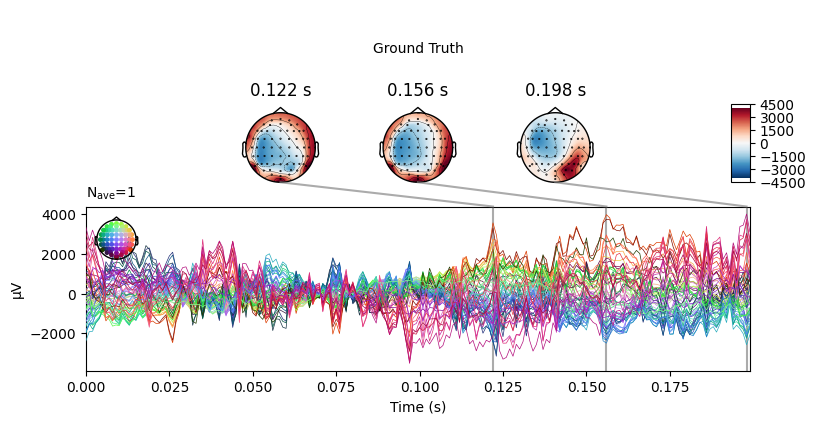

Using control points [0.00014563 0.00031428 0.00177044]
Using control points [0.00014563 0.00031428 0.00177044]


In [7]:
x, y = gen.__next__()

tmin = 0
tstep = 1/info["sfreq"]
subject = "fsaverage"
evoked = mne.EvokedArray(x[0].T, info, tmin=tmin)
stc = mne.SourceEstimate(y[0].T, vertices, tmin=tmin, tstep=tstep, 
                        subject=subject, verbose=0)

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, "Ground Truth", 'title',
               font_size=14)
evoked.plot_joint(title="Ground Truth")

In [17]:
from scipy.sparse.csgraph import laplacian
from copy import deepcopy

n_channels, n_dipoles = leadfield.shape

A = mne.spatial_src_adjacency(fwd['src'], verbose=0)
# G = abs(laplacian(A))
L = laplacian(A)
alpha = 0.1
LL = deepcopy(leadfield)
J = np.zeros((n_dipoles, 1))
idx = 99
J[idx] = 1
stc_ = stc.copy()

for k in range(0, 15):
    stc_.data = J
    if k % 5 == 0:
        stc_.plot(**pp, colormap="Reds")
        # brain.add_text(0.1, 0.9, f"Order k = {k}", 'title',
        #             font_size=14)
        evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
        evoked_.plot_joint(title=f"Order k = {k}")
    
    
    # new smoothing:
    J = (I - alpha*L) @ J
    
    # old
    # J = G @ J
    # LL = LL @ G



C:\Users\Lukas\AppData\Local\Temp\ipykernel_9536\1306089691.py:19: RuntimeWarning: All data were zero
  stc_.plot(**pp, colormap="Reds")


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


c:\Users\Lukas\Envs\invertenv\lib\site-packages\mne\viz\evoked.py:554: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


c:\Users\Lukas\Envs\invertenv\lib\site-packages\mne\viz\evoked.py:554: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


c:\Users\Lukas\Envs\invertenv\lib\site-packages\mne\viz\evoked.py:554: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)


Using control points [1.9890000e-06 8.1792475e-05 3.8474230e-02]
Using control points [1.9890000e-06 8.1792475e-05 3.8474230e-02]
Using control points [1.9890000e-06 8.1792475e-05 3.8474230e-02]


# Solve

## FLAP

In [6]:
from invert import Solver

solver = Solver("Flex-AP", n_orders=3)
solver.make_inverse_operator(fwd, evoked, refine_solution=True, stop_crit=0.95, n=sim_params["n_sources"])
stc_ = solver.apply_inverse_operator(evoked)

stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

print(solver.name, " r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])

n_comp:  2
[[1, 1211], [2, 4053]]
[0.99973734 0.99999353 0.99379172 0.9689102 ]
[0.99876987 0.99891604 0.99943507 0.9987179 ]
stopping refinement at iter  0
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Flexible Alternating Projections  r =  0.9677709804526521


Using control points [0.         0.         0.00018105]
Using control points [0.         0.         0.15242983]


## FLEX-MUSIC

In [115]:
from invert import Solver

solver = Solver("Flex-Music", n_orders=3)
solver.make_inverse_operator(fwd, evoked, refine_solution=True, stop_crit=0.95, n=sim_params["n_sources"])
stc_ = solver.apply_inverse_operator(evoked)

stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

print(solver.name, " r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])

n_comp:  4
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
FLEX-MUSIC  r =  0.17995034386547926


Using control points [0.00141905 0.00478115 0.26155759]


In [16]:
fwd["sol"]["data"].shape

(64, 1284)

[632, 778]
[90, 778]
[90, 778]
No improvement vs. previous iteration 2
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


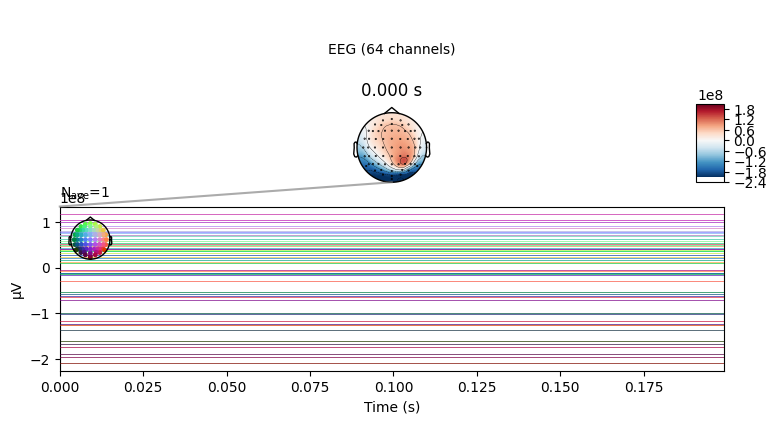

In [82]:
y = evoked.data
y -= y.mean(axis=0)
S_AP, S_AP_2 = alternating_projections(y, fwd["sol"]["data"], 2, mode="AP")

stc_.data *= 0
# stc_.data[S_AP] = 1
stc_.data[S_AP_2] = 1
stc_.plot(**pp)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()


In [17]:
import numpy as np

def alternating_projections(Y, Gain, nsources, mode="AP"):
    """
    Function to perform Alternating Projections on a given data set.

    Parameters:
    Y: input data
    ndipoles: number of dipoles topographies
    Gain: Gain matrix
    nsources: number of sources
    max_iters: maximum number of iterations
    mode: mode of operation ('AP', 'AP-w-MUSIC', 'AP-MUSIC')

    Returns:
    S_AP: AP localization of sources after 1st Phase
    S_AP_2: AP localization of sources after 2nd Phase
    """
    ndipoles = Gain.shape[1]
    max_iters=100
    
    # AP localization of 1st source
    Y = np.array(Y)
    Gain = np.array(Gain)
    S_AP = []

    if mode == 'AP':
        C = np.matmul(Y,Y.T) + 1e-3 * np.trace(np.matmul(Y,Y.T)) * np.eye(Y.shape[0]) # Array Covariance matrix
    elif mode == 'AP-w-MUSIC':
        u,s,_ = np.linalg.svd(np.matmul(Y,Y.T)) # Array Covariance matrix
        C = np.matmul(np.matmul(u[:,:nsources], np.diag(s[:nsources])), u[:,:nsources].T)
    elif mode == 'AP-MUSIC':
        u,_,_ = np.linalg.svd(np.matmul(Y,Y.T)) # Array Covariance matrix
        C = np.matmul(u[:,:nsources], u[:,:nsources].T)

    ap_val1 = np.zeros((ndipoles,1))

    # 1st Phase
    # a) Initialization: search the 1st source location over the entire
    # dipoles topographies space (ndipoles=15,002 topographies)
    for p in range(ndipoles):
        l_p = Gain[:,p]
        ap_val1[p] = np.matmul(np.matmul(l_p.T,C),l_p) / np.matmul(l_p.T,l_p)

    s1_idx = np.argmax(ap_val1) # obtain the 1st source location
    S_AP.append(s1_idx)

    # (b) Now, add one source at a time
    for q in range(1, nsources):
        # AP localization of q-th source
        ap_val2 = np.zeros((ndipoles,1))
        A = Gain[:,S_AP]
        P_A = np.matmul(A, np.linalg.pinv(np.matmul(A.T,A))) @ A.T
        Q = np.eye(P_A.shape[0]) - P_A
        for p in range(ndipoles):
            l_p = Gain[:,p]
            ap_val2[p] = np.matmul(np.matmul(np.matmul(l_p.T,Q),C), Q @ l_p) / np.matmul(l_p.T, Q @ l_p)

        s2_idx = np.argmax(ap_val2)
        S_AP.append(s2_idx)

    # 2nd Phase
    S_AP_2 = S_AP.copy()
    for iter in range(max_iters):
        print(S_AP_2)
        S_AP_2_Prev = S_AP_2.copy()
        for q in range(nsources):
            # AP localization of q-th source
            ap_val2 = np.zeros((ndipoles,1))
            S_AP_TMP = S_AP_2.copy()
            S_AP_TMP.pop(q)
            A = Gain[:,S_AP_TMP]
            P_A = np.matmul(A, np.linalg.pinv(np.matmul(A.T,A))) @ A.T
            Q = np.eye(P_A.shape[0]) - P_A
            for p in range(ndipoles):
                l_p = Gain[:,p]
                ap_val2[p] = np.matmul(np.matmul(np.matmul(l_p.T,Q),C), Q @ l_p) / np.matmul(l_p.T, Q @ l_p)

            sq_idx = np.argmax(ap_val2)
            S_AP_2[q] = sq_idx

        if iter>1 and S_AP_2 == S_AP_2_Prev:
            # No improvement vs. previous iteration
            print(f"No improvement vs. previous iteration {iter}")
            break

    return S_AP, S_AP_2

# Other

In [26]:
from invert import Solver
solver = Solver("FLEX")
solver.make_inverse_operator(fwd, evoked, alpha="auto")

stc_ = solver.apply_inverse_operator(evoked)

stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

print("r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])
print("L1 = ",  np.linalg.norm(stc_.data, ord=1))

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
r =  0.6948346974579134
L1 =  1.858965745005016


Using control points [0.         0.         0.21985127]
Using control points [0.         0.         0.21985127]
Using control points [0.         0.         0.00074315]


In [71]:
from invert.ensemble import Ensemble
solver_list = ["wMNE", "sLORETA", "LAURA", "Convexity Champagne", "GAMMA-MAP", "HOCMCMV", "SSMP", "FLEX-MUSIC"]

solver = Ensemble(solver_list, summary_type="mean")
solver.make_inverse_operator(fwd, evoked)

stc_ = solver.apply_inverse_operator(evoked)

stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

print("r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])
print("L1 = ",  np.linalg.norm(stc_.data, ord=1))


Neg Log Likelihoods:
Weighted Minimum Norm Estimate: 2.9394164039239108e+16
Standardized Low Resolution Tomography: 7056644664954265.0
Local Auto-Regressive Average: 4.146360417359438e+16
Convexity-Champagne: 4.2470080857763565e+17
Gamma-MAP: 3.1260108546333396e+21
HOCMCMV Beamformer: 1.910786963009039e+16
Smooth Simultaneous Matching Pursuit: 3.5832611079591326e+19
FLEX-MUSIC: 1.5352123438904883e+21
Final likelihood: 3.710577509644482e+16

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
r =  0.5801999577680862
L1 =  19.037933114897022


Using control points [0.00000000e+00 1.65519602e-05 1.04781600e-03]
Using control points [0.01916428 0.02408992 0.33659396]
Using control points [0.02326119 0.02898724 0.3457652 ]
Using control points [0.00000000e+00 2.30515891e-05 8.79191639e-04]
Using control points [0.01387627 0.01928899 0.32717469]
Using control points [0.01650014 0.02247438 0.32797067]
Using control points [0.01387627 0.01928899 0.32717469]
Using control points [0.01650014 0.02247438 0.32797067]
Using control points [0.00000000e+00 2.30515891e-05 8.79191639e-04]


In [36]:
from invert.solvers import SolverFLEXMUSIC_2
solver = SolverFLEXMUSIC_2()
solver.make_inverse_operator(fwd, evoked, alpha="auto")

stc_ = solver.apply_inverse_operator(evoked)

stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

print("r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])
print("L1 = ",  np.linalg.norm(stc_.data, ord=1))

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
r =  0.1500066745955677
L1 =  2.440536143086816


Using control points [0.         0.         0.18246018]


# Big Loop

In [ ]:
from invert import Solver
# from invert.config import all_solvers
from invert.evaluate import nmse, corr, eval_mean_localization_error, eval_auc
from invert.adapters import contextualize_bd
import pickle as pkl


all_solvers = [ "MNE", "wMNE", "dSPM", "FISTA", "L1L2",
                "LORETA", "sLORETA", "eLORETA", 
                "LAURA", "Backus-Gilbert", 
                "S-MAP",
                "Champagne", "Multiple Sparse Priors", "Bayesian LORETA", "Bayesian MNE", "Bayesian Beamformer", "Bayesian Beamformer LORETA",
                "BCS", "Gamma-MAP", "Source-MAP", "Gamma-MAP-MSP", "Source-MAP-MSP",
                "MVAB", "LCMV", "SMV", "WNMV", "HOCMV", "ESMV", "MCMV", "ESMCMV", "ReciPSIICOS", "SAM",
                # "Fully-Connected", 
                # "LUCAS",
                # "OMP", "COSAMP", "SOMP", "REMBO", "SP", "SSP",
                # "SMP", "SSMP", "SubSMP",
                "EPIFOCUS",
                "MUSIC", "RAP-MUSIC", "TRAP-MUSIC", "JAZZ-MUSIC",
            ]
redo_solvers = np.array(["Champagne", "Multiple Sparse Priors", 
            "Bayesian LORETA", "Bayesian MNE", "Bayesian Beamformer", 
            "Bayesian Beamformer LORETA", "Gamma-MAP", "Source-MAP"])

all_solvers = ["TRAP-MUSIC", "JAZZ-MUSIC", "LCMV", "sLORETA"]

settings = dict(
    number_of_sources=(1, 10), 
    extents=(1, 25), 
    duration_of_trial=1, 
    target_snr=(1, 100))
alpha = "auto"

errors_corr = {sname: [] for sname in all_solvers}
errors_mle = {sname: [] for sname in all_solvers}
errors_auc = {sname: [] for sname in all_solvers}
errors_nmse = {sname: [] for sname in all_solvers}

solvers = dict()
sim = Simulation(fwd, info, settings).simulate(100)
    
for i in range(sim.n_samples):
    print(i)
    stc = sim.source_data[i]
    evoked = sim.eeg_data[i].average()

    for solver_name in all_solvers :
        print(solver_name)
        solver = Solver(solver=solver_name)
        if (not solver_name in solvers) or solver_name in redo_solvers:
            if solver_name == "Fully-Connected":
                solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha=alpha, settings=dict(duration_of_trial=0., target_snr=settings["target_snr"], extents=settings["extents"]), n_simulations=5000)
            else:
                solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha=alpha)
        # stc_hat.plot(**pp, brain_kwargs=dict(title=solver.name))
        # error = np.mean(corr(stc.data, stc_hat.data))
        
        try:
            stc_hat = solvers[solver_name].apply_inverse_operator(evoked)
            error_corr = np.mean(corr(stc.data, stc_hat.data))

            error_mle = eval_mean_localization_error(stc.data[:, 0], stc_hat.data[:, 0], pos)
            error_auc = eval_auc(stc.data[:, 0], stc_hat.data[:, 0], pos)
            error_nmse = np.median(nmse(stc.data, stc_hat.data))

        except:
            print("\t...didnt work this time")
            error_mle = np.nan
            error_auc = np.nan
            error_corr = np.nan
            error_nmse = np.nan

        errors_corr[solver_name].append( error_corr )
        errors_mle[solver_name].append( error_mle )
        errors_auc[solver_name].append( error_auc )
        errors_nmse[solver_name].append( error_nmse )


    print("Saving errors")
    fn = "errors.pkl"
    with open(fn, 'wb') as f:
        pkl.dump([errors_corr, errors_mle, errors_auc, errors_nmse, sim.simulation_info], f)

In [ ]:
# import pickle as pkl
# fn = "errors.pkl"
# with open(fn, 'rb') as f:
#     errors_corr, errors_mle, errors_auc = pkl.load(f)

In [ ]:
# for key, val in errors_mle.items():
#     errors_mle[key] = val[:31]

# for key, val in errors_corr.items():
#     errors_mle[key] = val[:31]

# for key, val in errors_auc.items():
#     errors_mle[key] = val[:31]
    

# Plot

In [ ]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=0.8)
errors = [errors_corr, errors_mle, errors_auc, errors_nmse]
error_names = ["errors_corr", "errors_mle", "errors_auc", "errors_nmse"]
for error, error_name in zip(errors, error_names):
    df = pd.DataFrame(error)


    sorted_index = df.median().sort_values().index
    df = df[sorted_index]

    plt.figure()
    sns.boxplot(data=df)
    plt.title(error_name)


# df_mean_var = pd.concat([df.mean(), df.std()], axis=1)
# df_mean_var = df_mean_var.rename(columns={0: "Median", 1: "Variance"})
# df_mean_var["MedVar"] = df_mean_var["Median"] / df_mean_var["Variance"]
# df_mean_var["Method"] = df_mean_var.index
# df_mean_var = df_mean_var.sort_values(by="Median")
# display(df_mean_var)

# plt.figure()
# sns.scatterplot(x="Median", y="Variance", hue="Method", size="MedVar", data=df_mean_var)
# plt.xlabel("Median")
# plt.ylabel("Variance")


In [ ]:
settings = dict(number_of_sources=3, extents=(25, 35), duration_of_trial=0.025, target_snr=99999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)